In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as dates
matplotlib.rcParams['figure.figsize'] = (10., 6.)
#plt.style.use('seaborn-poster')
from scipy import optimize
from scipy.interpolate import CubicSpline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import explained_variance_score
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from prettytable import PrettyTable  
import copy
import scipy as sp
import datetime as dt
import timeit
import time
import sys
sys.path.insert(0, '../../Utilities/')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
np.set_printoptions(threshold=np.inf)


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
data =pd.read_csv("EINN_21day.csv")

alpha1 = 1.0
alpha2 = 1.0

POINTS = 1
SEED = 123
GRID = 9

layers = [1,128,128,128,128, 8]

N0 = 6629870
lb = 0 
ub = 21
length=int(ub-lb)

npoints = ub * POINTS
epochs = 100000

learning_rate = 1e-6

In [3]:
birth_rt = 0.000053
death_rt = 0.000033

alpha_cal = 0.00171
sigma_cal = 0.00529
beta1_cal = 0.34863
beta2_cal = 0.22323
beta3_cal = 0.06289
delta1_cal = 0.30836
delta2_cal = 0.20983
delta3_cal = 0.07253
gamma_cal = 0.22657
p1_cal = 0.02337
p2_cal = 0.08008
mu_cal = 0.00532



In [4]:
np.random.seed(SEED)
tf.set_random_seed(SEED)
#tf.compat.v1.disable_eager_execution()

class ClipConstraint(tf.keras.constraints.Constraint):
    def __init__(self, min_value, max_value):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, w):
        return tf.clip_by_value(w, self.min_value, self.max_value)

class SIR:
    def __init__(self, S, V, E, I1, I2, I3, R, D, T, layers, alpha1, alpha2):
        self.t = T
        self.S = S
        self.V = V
        self.E = E
        self.I1 = I1
        self.I2 = I2
        self.I3 = I3
        self.R = R
        self.D = D
        self.learning_rate = learning_rate
        
        self.alpha1, self.alpha2 = alpha1, alpha2
        self.layers = layers
        self.lb = T.min()
        self.ub = T.max()
        
        tf.set_random_seed(SEED)
        self.birth = tf.Variable(birth_rt ,dtype=tf.float32,trainable=False)
        self.dead = tf.Variable(death_rt,dtype=tf.float32,trainable=False)

        #trainable parameters
        self.grid = GRID
        self.alpha = tf.Variable(alpha_cal,dtype=tf.float32,trainable=False)
        self.sigma = tf.Variable(sigma_cal,dtype=tf.float32,trainable=False)
        self.beta1 = tf.Variable(beta1_cal,dtype=tf.float32,trainable=False)
        self.beta2 = tf.Variable(beta2_cal,dtype=tf.float32,trainable=False)
        self.beta3 = tf.Variable(beta3_cal,dtype=tf.float32,trainable=False)
        self.delta1 = tf.Variable(delta1_cal,dtype=tf.float32,trainable=False)
        self.delta2 = tf.Variable(delta2_cal,dtype=tf.float32,trainable=False)
        self.delta3 = tf.Variable(delta3_cal,dtype=tf.float32,trainable=False)
        self.mu = tf.Variable(mu_cal,dtype=tf.float32,trainable=False)
        self.gamma = tf.Variable(gamma_cal,dtype=tf.float32,trainable=False)
        self.p1 = tf.Variable(p1_cal,dtype=tf.float32,trainable=False)
        self.p2 = tf.Variable(p2_cal,dtype=tf.float32,trainable=False)
        
        tf.set_random_seed(SEED)
        # Initialize NN
        self.weights1, self.biases1 = self.initialize_NN(self.layers)
        self.weights2, self.biases2 = self.initialize_NN(self.layers)
        self.weights3, self.biases3 = self.initialize_NN(self.layers)
        self.weights4, self.biases4 = self.initialize_NN(self.layers)
        self.weights5, self.biases5 = self.initialize_NN(self.layers)
        self.weights6, self.biases6 = self.initialize_NN(self.layers)
        self.weights7, self.biases7 = self.initialize_NN(self.layers)
        self.weights8, self.biases8 = self.initialize_NN(self.layers)
        self.weights9, self.biases9 = self.initialize_NN(self.layers)
     
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.S_tf = tf.placeholder(tf.float32, shape=[None, self.S.shape[1]])
        self.V_tf = tf.placeholder(tf.float32, shape=[None, self.V.shape[1]])
        self.E_tf = tf.placeholder(tf.float32, shape=[None, self.E.shape[1]])
        self.I1_tf = tf.placeholder(tf.float32, shape=[None, self.I1.shape[1]])
        self.I2_tf = tf.placeholder(tf.float32, shape=[None, self.I2.shape[1]])
        self.I3_tf = tf.placeholder(tf.float32, shape=[None, self.I3.shape[1]])
        self.R_tf = tf.placeholder(tf.float32, shape=[None, self.R.shape[1]])
        self.D_tf = tf.placeholder(tf.float32, shape=[None, self.D.shape[1]])
        
        #lossess
        self.total_loss =[]
        self.loss_data =[]
        self.loss_res =[]
        
        self.S_pred, self.V_pred, self.E_pred, self.I1_pred, self.I2_pred, self.I3_pred, self.R_pred, self.D_pred = self.net_sir(self.t_tf)
        
        self.e1, self.e2, self.e3, self.e4, self.e5, self.e6, self.e7, self.e8  = self.net_residual(self.t_tf)
        
        self.lossRes = tf.reduce_mean(tf.square(self.e1)) + tf.reduce_mean(tf.square(self.e2)) +\
                        tf.reduce_mean(tf.square(self.e3)) + tf.reduce_mean(tf.square(self.e4)) +\
                        tf.reduce_mean(tf.square(self.e5)) + tf.reduce_mean(tf.square(self.e6)) +\
                        tf.reduce_mean(tf.square(self.e7)) + tf.reduce_mean(tf.square(self.e8)) 


        self.S_loss =tf.reduce_mean(tf.square(self.S_tf - self.S_pred))
        self.V_loss =tf.reduce_mean(tf.square(self.V_tf - self.V_pred))
        self.E_loss =tf.reduce_mean(tf.square(self.E_tf - self.E_pred))
        self.I1_loss =tf.reduce_mean(tf.square(self.I1_tf - self.I1_pred))
        self.I2_loss =tf.reduce_mean(tf.square(self.I2_tf - self.I2_pred))
        self.I3_loss =tf.reduce_mean(tf.square(self.I3_tf - self.I3_pred))
        self.R_loss =tf.reduce_mean(tf.square(self.R_tf - self.R_pred))
        self.D_loss =tf.reduce_mean(tf.square(self.D_tf - self.D_pred))  

        self.lossData = self.S_loss + self.V_loss + self.E_loss + self.I1_loss + self.I2_loss + self.I3_loss + self.R_loss + self.D_loss

        alpha1, alpha2 =self.alpha1, self.alpha2
        
        self.loss = alpha1*self.lossData + alpha2*self.lossRes

        self.optimizer_Adam = tf.compat.v1.train.AdamOptimizer(self.learning_rate)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        
        # Optimizers                                                                                    
        init = tf.global_variables_initializer()
        self.sess.run(init)
         
        
    def initialize_NN(self, layers):        
        tf.set_random_seed(SEED)
        weights = []
        biases = []
        num_layers = len(layers)
        
        for l in range(0,num_layers-1):
            tf.set_random_seed(SEED)
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def xavier_init(self, size):
        tf.set_random_seed(SEED)
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.random.truncated_normal([in_dim, out_dim], stddev=xavier_stddev, seed=SEED), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.softplus(tf.add(tf.matmul(H, W), b))
        return Y

    def neural_net1(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.nn.sigmoid(tf.add(tf.matmul(H, W), b))
        return Y
    
    def net_sir(self, t):
        SIR = self.neural_net1(t, self.weights1, self.biases1)
        S, V, E, I1, I2, I3, R, D = SIR[:,0:1], SIR[:,1:2], SIR[:,2:3], SIR[:,3:4], SIR[:,4:5], SIR[:,5:6], SIR[:,6:7], SIR[:,7:8]
        return S, V, E, I1, I2, I3, R, D
    

    def net_residual(self, t):
        S, V, E, I1, I2, I3, R, D = self.net_sir(t)
        N = S + V + E + I1 + I2 + I3 + R + D

        birth = self.birth
        dead = self.dead
        
        alpha = self.alpha
        sigma = self.sigma
        beta1 = self.beta1
        beta2 = self.beta2
        beta3 = self.beta3
        delta1 = self.delta1
        delta2 = self.delta2
        delta3 = self.delta3
        mu = self.mu
        gamma = self.gamma
        p1 = self.p1
        p2 = self.p2

        St = tf.gradients(S, t)[0]
        Vt = tf.gradients(V, t)[0]  
        Et = tf.gradients(E, t)[0]
        I1t = tf.gradients(I1, t)[0]  
        I2t = tf.gradients(I2, t)[0]
        I3t = tf.gradients(I3, t)[0]  
        Rt = tf.gradients(R, t)[0]
        Dt = tf.gradients(D, t)[0]  
                
        e1 = St - (birth  - ( beta1 * I1 + beta2 * I2 + beta3 * I3) * S  - alpha * S - dead*S)  
        e2 = Vt - (alpha * S - sigma * (beta1 * I1 + beta2 * I2 + beta3 * I3) * V  - dead*V) 
        e3 = Et - ((beta1 * I1 + beta2 * I2 + beta3 * I3) * S+ sigma * (beta1 * I1 + beta2 * I2 + beta3 * I3) * V - gamma * E- dead*E)
        e4 = I1t - (gamma * E - (delta1 + p1) * I1- dead*I1) 
        e5 = I2t - (p1 * I1 - (delta2 + p2) * I2- dead*I2) 
        e6 = I3t - (p2 * I2 - (delta3 + mu) * I3- dead*I3) 
        e7 = Rt - (delta1 * I1+ delta2 * I2 + delta3 * I3- dead*R) 
        e8 = Dt - (mu * I3)

        return e1, e2, e3, e4, e5, e6, e7, e8

    def callback(self, loss):
        print('Loss: %.3e' % (loss))
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, 
                   self.S_tf: self.S,
                   self.V_tf: self.V,
                   self.E_tf: self.E,
                   self.I1_tf: self.I1,
                   self.I2_tf: self.I2,
                   self.I3_tf: self.I3,
                   self.R_tf: self.R,
                   self.D_tf: self.D,
                  }
                   
        start_time = time.time()
        loss_seq = []
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_t = self.sess.run(self.loss, tf_dict)
            loss_d = self.sess.run(self.lossData, tf_dict)
            loss_p = self.sess.run(self.lossRes, tf_dict)
            self.total_loss.append(loss_t)
            self.loss_data.append(loss_d)
            self.loss_res.append(loss_p)
            
            # Print
            if it % 500 == 0:
                elapsed = time.time() - start_time
                loss_t = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_t, elapsed))
                #start_time = time.time()

            if it % 1 == 0:
                loss_seq.append(loss_t)

        return loss_seq
        
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        S = self.sess.run(self.S_pred, tf_dict)
        V = self.sess.run(self.V_pred, tf_dict)
        E = self.sess.run(self.E_pred, tf_dict)
        I1 = self.sess.run(self.I1_pred, tf_dict)
        I2 = self.sess.run(self.I2_pred, tf_dict)
        I3 = self.sess.run(self.I3_pred, tf_dict)
        R = self.sess.run(self.R_pred, tf_dict)
        D = self.sess.run(self.D_pred, tf_dict)
        return S, V, E, I1, I2, I3, R, D

In [5]:
def data_preprocess(data, lb, ub, npoints):
    tdat = data.reindex(index=data.index[::1])
    s_real = tdat["S"]
    v_real = tdat["V"]
    e_real = tdat["E"]
    i1_real = tdat["I1"]
    i2_real = tdat["I2"]
    i3_real = tdat["I3"]
    r_real = tdat["R"]
    d_real = tdat["D"]

    S_s =np.array(s_real.values).reshape((-1,1))
    V_s =np.array(v_real.values).reshape((-1,1))
    E_s =np.array(e_real.values).reshape((-1,1))
    I1_s =np.array(i1_real.values).reshape((-1,1))
    I2_s =np.array(i2_real.values).reshape((-1,1))
    I3_s =np.array(i3_real.values).reshape((-1,1))
    R_s =np.array(r_real.values).reshape((-1,1))
    D_s =np.array(d_real.values).reshape((-1,1))
    
    S = S_s[lb:ub,:]
    V = V_s[lb:ub,:]
    E = E_s[lb:ub,:]
    I1 = I1_s[lb:ub,:]
    I2 = I2_s[lb:ub,:]
    I3 = I3_s[lb:ub,:]
    R = R_s[lb:ub,:]
    D = D_s[lb:ub,:]
    
    tf.set_random_seed(SEED)
    np.random.seed(SEED)
    length = int(ub-lb)
    T = np.arange(0, length)
    S_spline = CubicSpline(T, S)
    V_spline = CubicSpline(T, V)
    E_spline = CubicSpline(T, E)
    I1_spline = CubicSpline(T, I1)
    I2_spline = CubicSpline(T, I2)
    I3_spline = CubicSpline(T, I3)
    R_spline = CubicSpline(T, R)
    D_spline = CubicSpline(T, D)
    
    # convert real data to match the desired data frequency 
    tt = np.linspace(0, length, npoints)
    t_s, S_s, V_s, E_s, I1_s, I2_s, I3_s, R_s, D_s = tt, S_spline(tt), V_spline(tt), E_spline(tt), I1_spline(tt), I2_spline(tt), I3_spline(tt), R_spline(tt), D_spline(tt)

    N_t = S_s + V_s + E_s + I1_s + I2_s + I3_s + R_s + D_s
    
    t_aug = t_s.reshape((-1,1))
    S_aug = S_s.reshape((-1,1))/N_t
    V_aug = V_s.reshape((-1,1))/N_t
    E_aug = E_s.reshape((-1,1))/N_t
    I1_aug = I1_s.reshape((-1,1))/N_t
    I2_aug = I2_s.reshape((-1,1))/N_t
    I3_aug = I3_s.reshape((-1,1))/N_t
    R_aug = R_s.reshape((-1,1))/N_t
    D_aug = D_s.reshape((-1,1))/N_t
    
    return S_aug, V_aug, E_aug, I1_aug, I2_aug, I3_aug, R_aug, D_aug, t_aug




Implement the output

In [6]:
tf.set_random_seed(SEED)
np.random.seed(SEED)
SS, VV, EE, I1I, I2I, I3I, RR, DD, T = data_preprocess(data, lb, ub, npoints)

tf.set_random_seed(SEED)
np.random.seed(SEED)
# training
model = SIR(SS, VV, EE, I1I, I2I, I3I, RR, DD, T, layers, alpha1, alpha2)
total_loss = model.train(epochs)

S_pred, V_pred, E_pred, I1_pred, I2_pred, I3_pred, R_pred, D_pred = model.predict(T)

alpha_v1 = model.sess.run(model.alpha)
sigma_v1 = model.sess.run(model.sigma)
beta1_v1 = model.sess.run(model.beta1)
beta2_v1 = model.sess.run(model.beta2)
beta3_v1 = model.sess.run(model.beta3)
delta1_v1= model.sess.run(model.delta1)
delta2_v1 = model.sess.run(model.delta2)
delta3_v1 = model.sess.run(model.delta3)
mu_v1 = model.sess.run(model.mu)
gamma_v1 = model.sess.run(model.gamma)
p1_v1 = model.sess.run(model.p1)
p2_v1 = model.sess.run(model.p2)

alpha = round(alpha_v1, 5)
sigma = round(sigma_v1, 5)
beta1 = round(beta1_v1, 5)
beta2 = round(beta2_v1, 5)
beta3 = round(beta3_v1, 5)
delta1 = round(delta1_v1, 5)
delta2 = round(delta2_v1, 5)
delta3 = round(delta3_v1, 5)
mu = round(mu_v1, 5)
gamma = round(gamma_v1, 5)
p1 = round(p1_v1, 5)
p2 = round(p2_v1, 5)


Device mapping: no known devices.
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_3: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_3/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_3/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_4: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_4/Assign: (Assig

In [7]:
print('alpha', alpha)
print('sigma',sigma) 
print('beta1',beta1) 
print('beta2',beta2)
print('beta3',beta3)
print('delta1',delta1)
print('delta2',delta2)
print('delta3',delta3)
print('mu',mu)
print('gamma',gamma)
print('p1',p1)
print('p2',p2)

alpha 0.00171
sigma 0.00529
beta1 0.34863
beta2 0.22323
beta3 0.06289
delta1 0.30836
delta2 0.20983
delta3 0.07253
mu 0.00532
gamma 0.22657
p1 0.02337
p2 0.08008


Calibrated Parameter Results

Error matrix
- RMSE
- MAPE

In [8]:
##Error
S_test_pred = S_pred.reshape(-1,) 
S_test_actual = SS.reshape(-1,)
S_rmse =np.sqrt(mean_squared_error(S_test_actual, S_test_pred))
S_mape =np.linalg.norm((S_test_pred-S_test_actual),2)/np.linalg.norm(S_test_actual, 2)   
print('S_RMSE',S_rmse)
print('S_MAPE',S_mape)

V_test_pred = V_pred.reshape(-1,) 
V_test_actual = VV.reshape(-1,)
V_rmse =np.sqrt(mean_squared_error(V_test_actual, V_test_pred))
V_mape =np.linalg.norm((V_test_pred-V_test_actual),2)/np.linalg.norm(V_test_actual, 2)   
print('V_RMSE',V_rmse)
print('V_MAPE',V_mape)

E_test_pred = E_pred.reshape(-1,)
E_test_actual = EE.reshape(-1,)
E_rmse =np.sqrt(mean_squared_error(E_test_actual, E_test_pred))
E_mape =np.linalg.norm((E_test_pred - E_test_actual),2)/np.linalg.norm(E_test_actual, 2)   
print('E_RMSE',E_rmse)
print('E_MAPE',E_mape)

I1_test_pred = I1_pred.reshape(-1,) 
I1_test_actual = I1I.reshape(-1,)
I1_rmse =np.sqrt(mean_squared_error(I1_test_actual, I1_test_pred))
I1_mape =np.linalg.norm((I1_test_pred-I1_test_actual),2)/np.linalg.norm(I1_test_actual, 2)   
print('I1_RMSE',I1_rmse)
print('I1_MAPE',I1_mape)

I2_test_pred = I2_pred.reshape(-1,) 
I2_test_actual = I2I.reshape(-1,)
I2_rmse =np.sqrt(mean_squared_error(I2_test_actual, I2_test_pred))
I2_mape =np.linalg.norm((I2_test_pred-I2_test_actual),2)/np.linalg.norm(I2_test_actual, 2)   
print('I2_RMSE',I2_rmse)
print('I2_MAPE',I2_mape)

I3_test_pred = I3_pred.reshape(-1,) 
I3_test_actual = I3I.reshape(-1,)
I3_rmse =np.sqrt(mean_squared_error(I3_test_actual, I3_test_pred))
I3_mape =np.linalg.norm((I3_test_pred-I3_test_actual),2)/np.linalg.norm(I3_test_actual, 2)   
print('I3_RMSE',I3_rmse)
print('I3_MAPE',I3_mape)

R_test_pred = R_pred.reshape(-1,) 
R_test_actual = RR.reshape(-1,)
R_rmse =np.sqrt(mean_squared_error(R_test_actual, R_test_pred))
R_mape =np.linalg.norm((R_test_pred - R_test_actual),2)/np.linalg.norm(R_test_actual, 2)   
print('R_RMSE', R_rmse)
print('R_MAPE', R_mape)

D_test_pred = D_pred.reshape(-1,) 
D_test_actual = DD.reshape(-1,)
D_rmse =np.sqrt(mean_squared_error(D_test_actual, D_test_pred))
D_mape =np.linalg.norm((D_test_pred-D_test_actual),2)/np.linalg.norm(D_test_actual, 2)   
print('D_RMSE',D_rmse)
print('D_MAPE',D_mape)

total_rmse = S_rmse + V_rmse + E_rmse + I1_rmse + I2_rmse + I3_rmse + R_rmse + D_rmse
total_mape = S_mape + V_mape + E_mape + I1_mape + I2_mape + I3_mape + R_mape + D_mape
print('TOTAL_RMSE', total_rmse)
print('TOTAL_MAPE', total_mape)

S_RMSE 0.001443516176489527
S_MAPE 0.007899512040376274
V_RMSE 0.00020161636728884466
V_MAPE 0.0002563378089751361
E_RMSE 0.002552638162544648
E_MAPE 0.2371140720727663
I1_RMSE 0.0005119171942317496
I1_MAPE 0.26697884807340333
I2_RMSE 3.656051694310325e-05
I2_MAPE 0.6965700656970801
I3_RMSE 1.8883472317513485e-05
I3_MAPE 1.8269415818519643
R_RMSE 0.0002038756322452234
R_MAPE 0.010870680072545007
D_RMSE 8.80871178897973e-05
D_MAPE 0.4079889315939216
TOTAL_RMSE 0.005057094639950407
TOTAL_MAPE 3.4546200292110325


Plot the fitted result


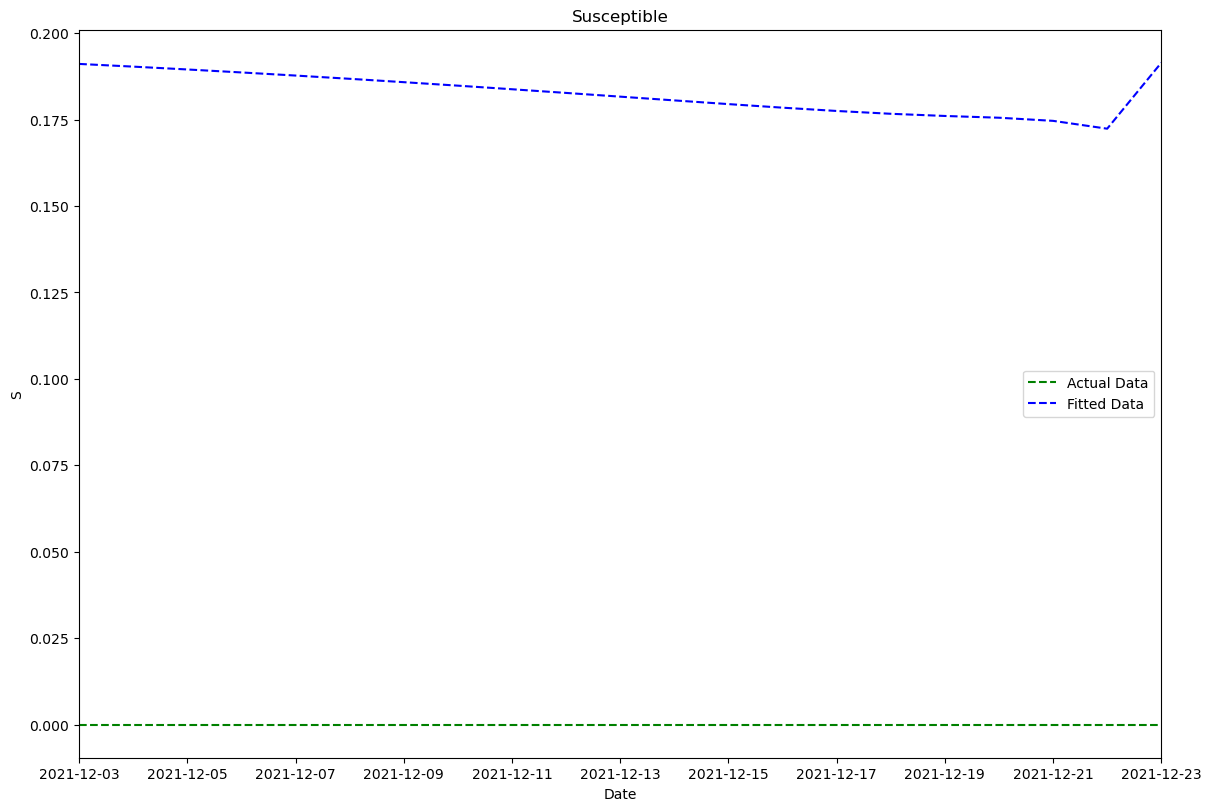

In [9]:
st ='2021-12-03'
ed ='2021-12-23'
date_begin = dt.date(2021, 12, 3)
date_end = date_begin + dt.timedelta(days=ub) 
delt = dt.timedelta(days=ub/npoints)
dates = mpl.dates.drange(date_begin, date_end, delt)
lims = (np.datetime64(st), np.datetime64(ed))

fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12,8))
ax1.plot(dates,SS/N0, '--g')
ax1.plot(dates,S_pred.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('S')
ax1.set_title('Susceptible')
ax1.set_xlim(lims)
ax1.legend(['Actual Data', r'Fitted Data'])

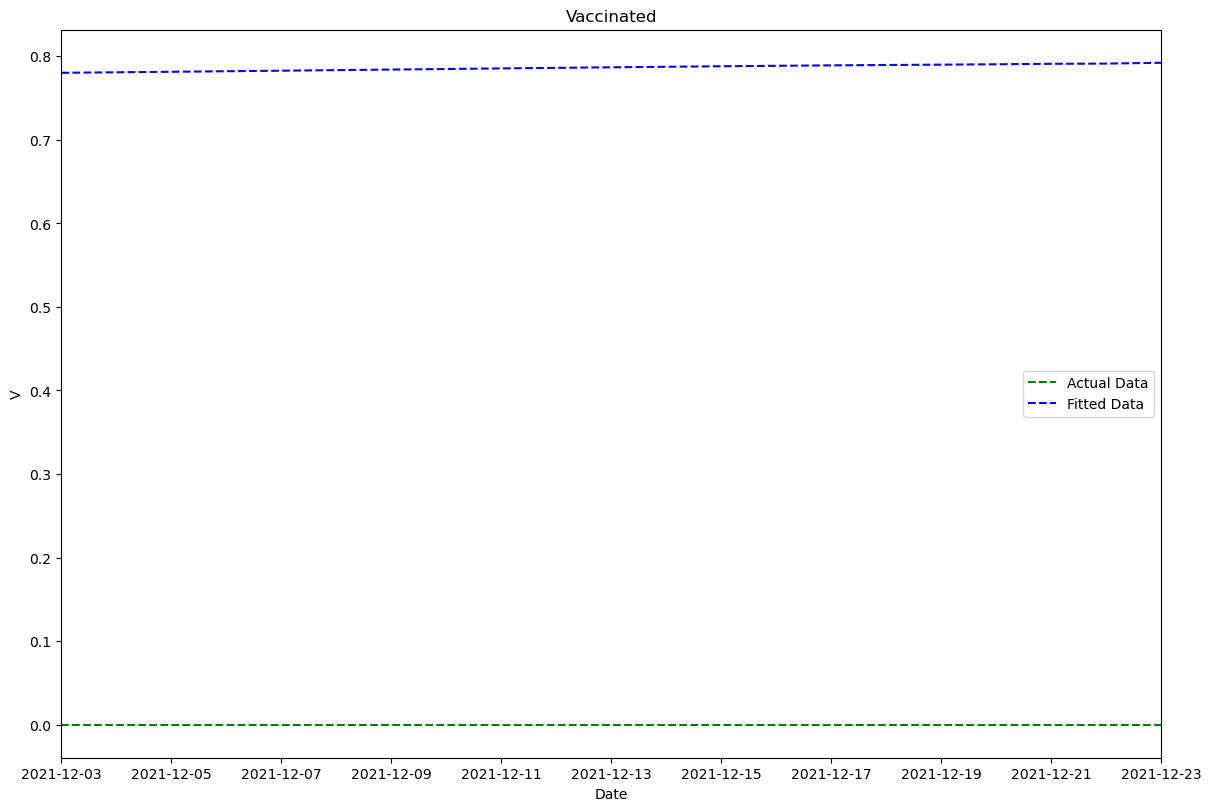

In [10]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,VV/N0, '--g')
ax1.plot(dates,V_pred.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('V')
ax1.set_title('Vaccinated')
ax1.set_xlim(lims)
ax1.legend(['Actual Data', r'Fitted Data'])

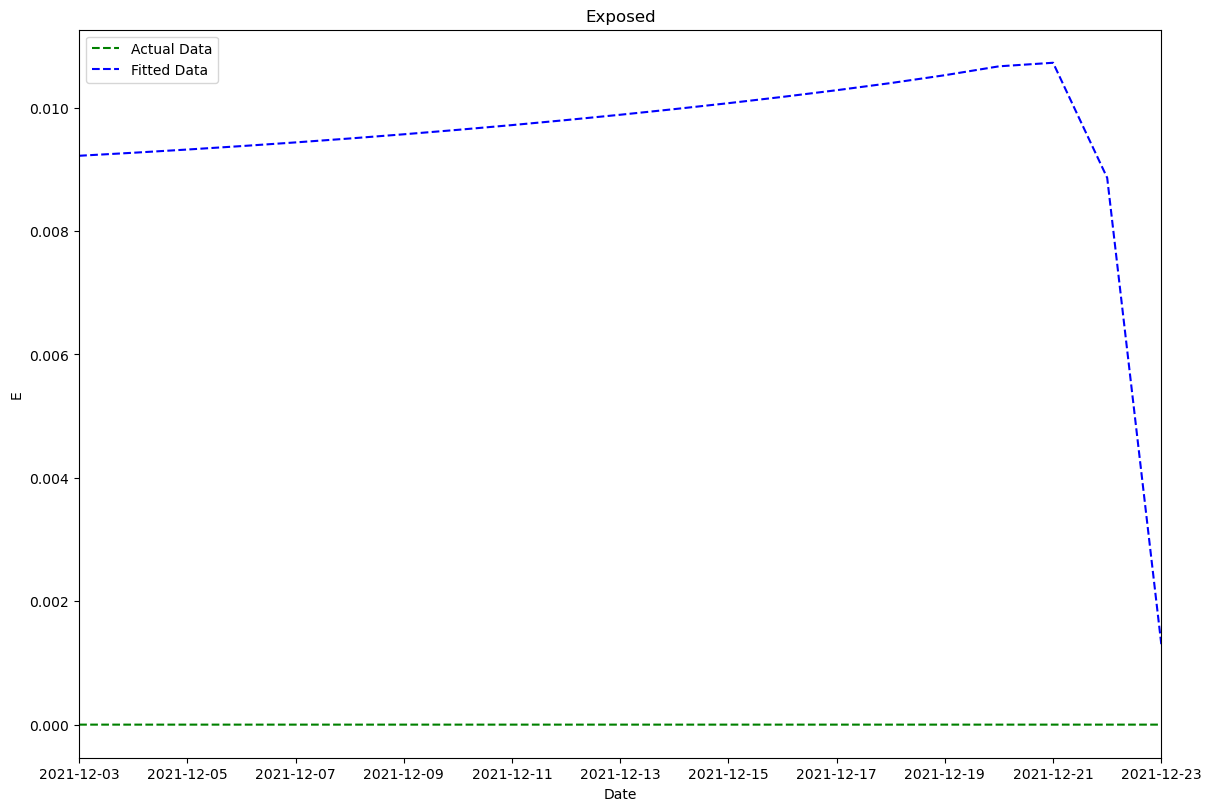

In [11]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,EE/N0, '--g')
ax1.plot(dates,E_pred.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('E')
ax1.set_title('Exposed')
ax1.set_xlim(lims)
ax1.legend(['Actual Data', r'Fitted Data'])

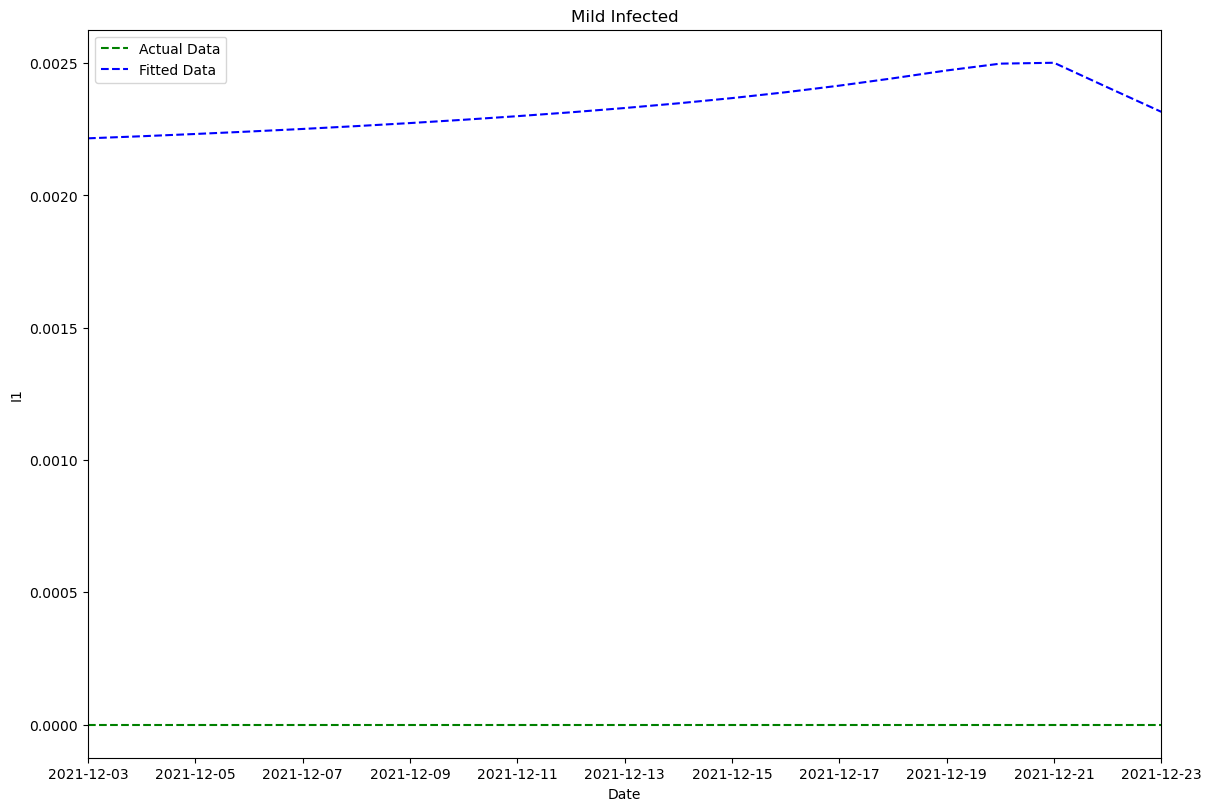

In [12]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,I1I/N0, '--g')
ax1.plot(dates,I1_pred.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('I1')
ax1.set_title('Mild Infected')
ax1.set_xlim(lims)
ax1.legend(['Actual Data', r'Fitted Data'])

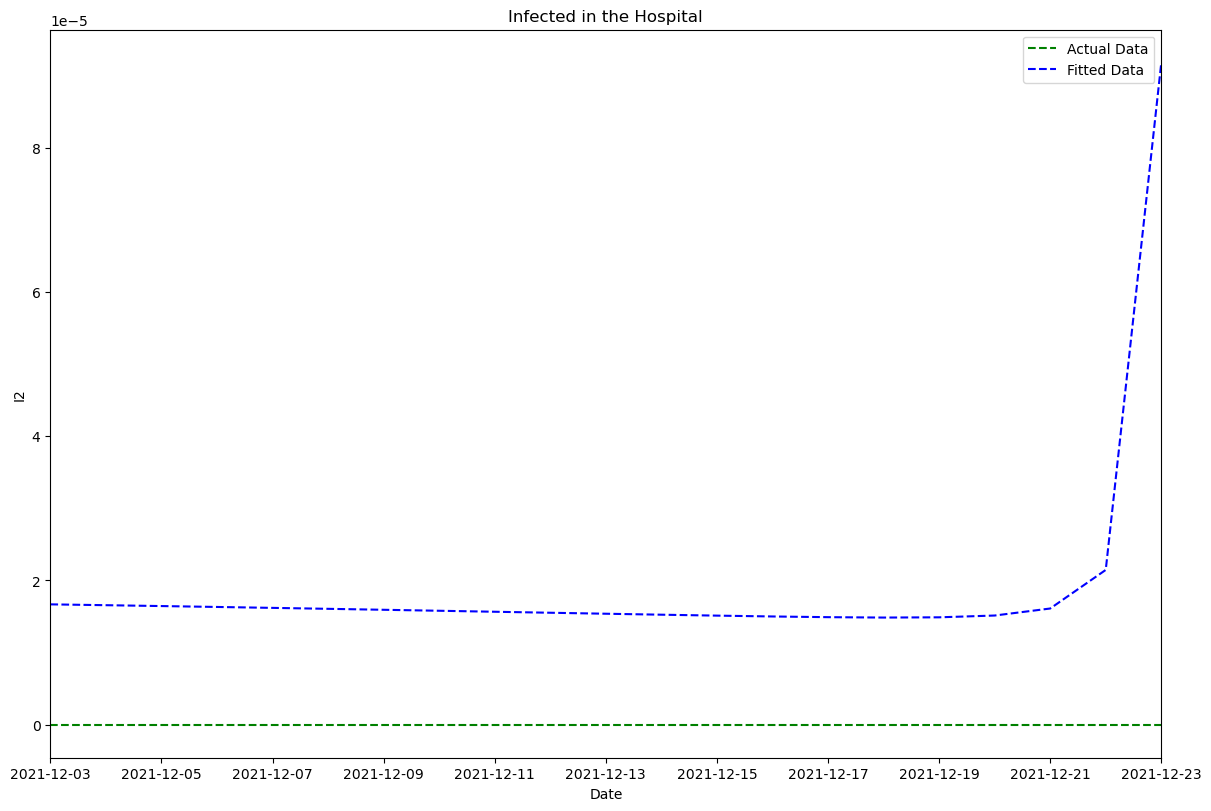

In [13]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,I2I/N0, '--g')
ax1.plot(dates,I2_pred.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('I2')
ax1.set_title('Infected in the Hospital')
ax1.set_xlim(lims)
ax1.legend(['Actual Data', r'Fitted Data'])

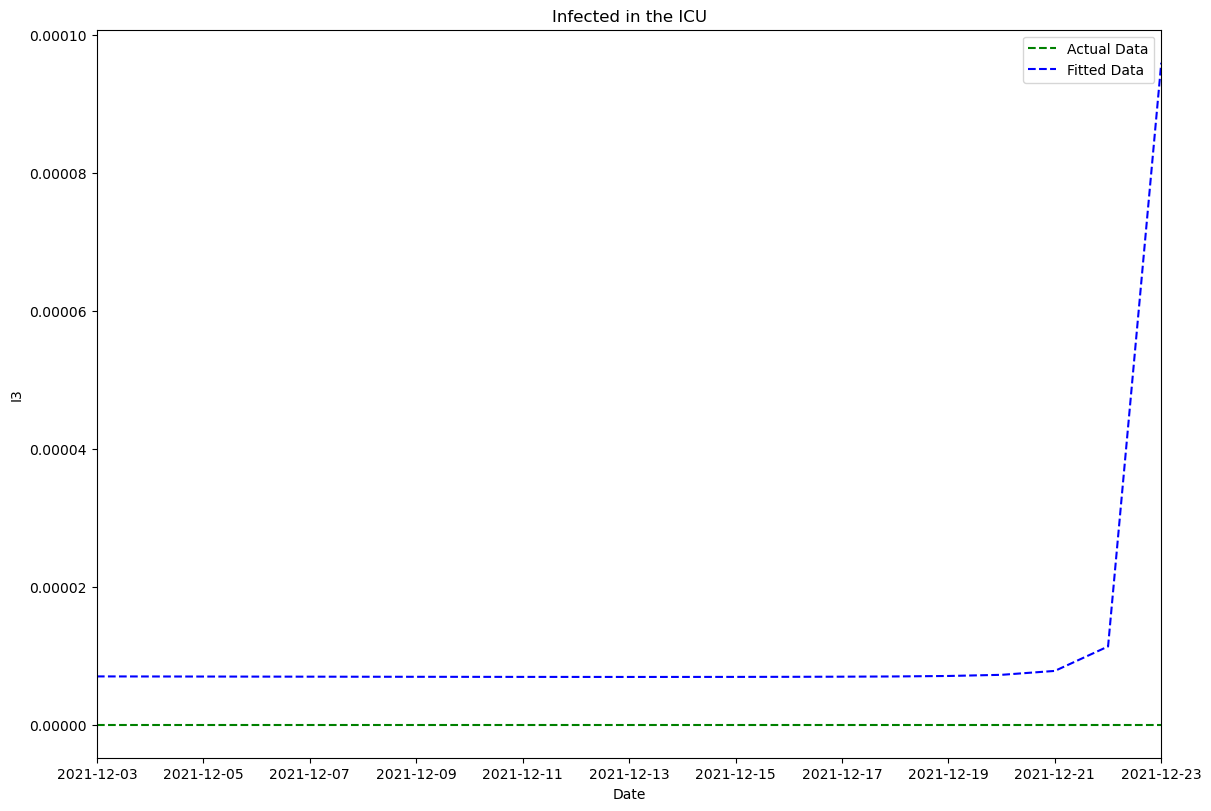

In [14]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,I3I/N0, '--g')
ax1.plot(dates,I3_pred.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('I3')
ax1.set_title('Infected in the ICU')
ax1.set_xlim(lims)
ax1.legend(['Actual Data', r'Fitted Data'])

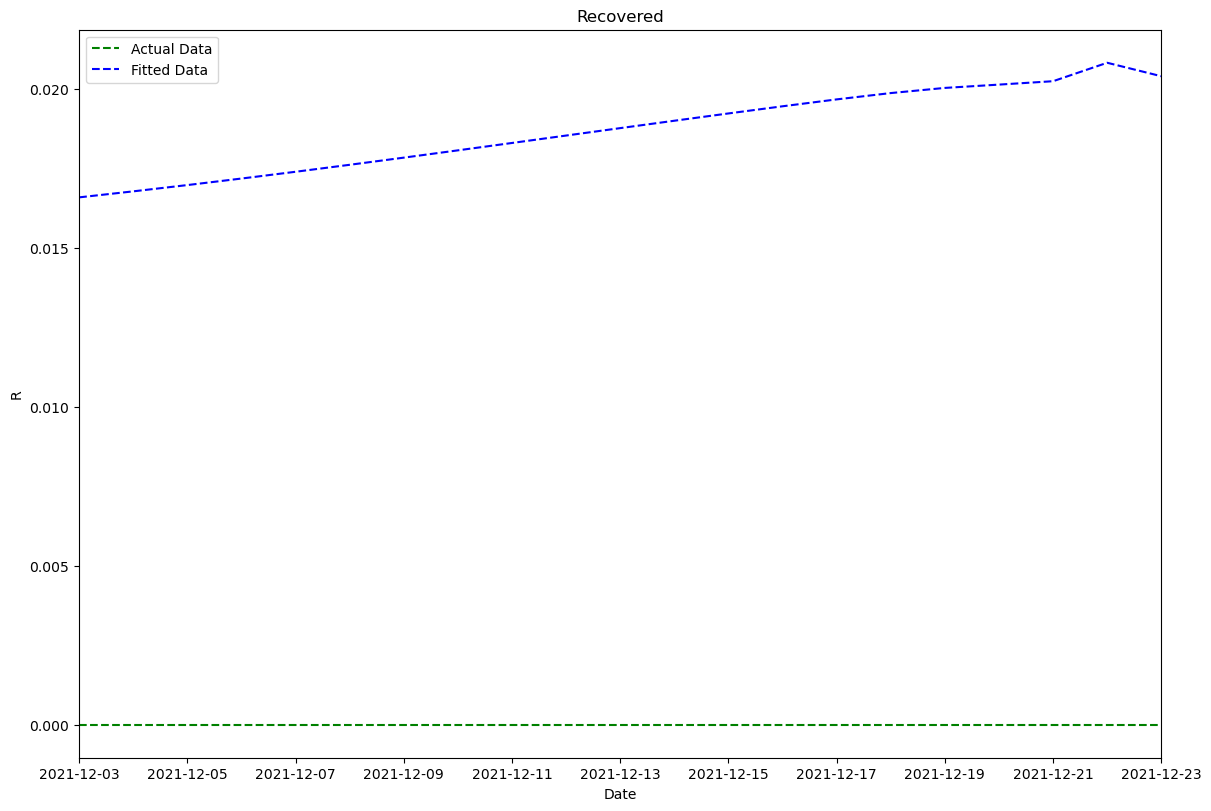

In [15]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,RR/N0, '--g')
ax1.plot(dates,R_pred.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('R')
ax1.set_title('Recovered')
ax1.set_xlim(lims)
ax1.legend(['Actual Data', r'Fitted Data'])

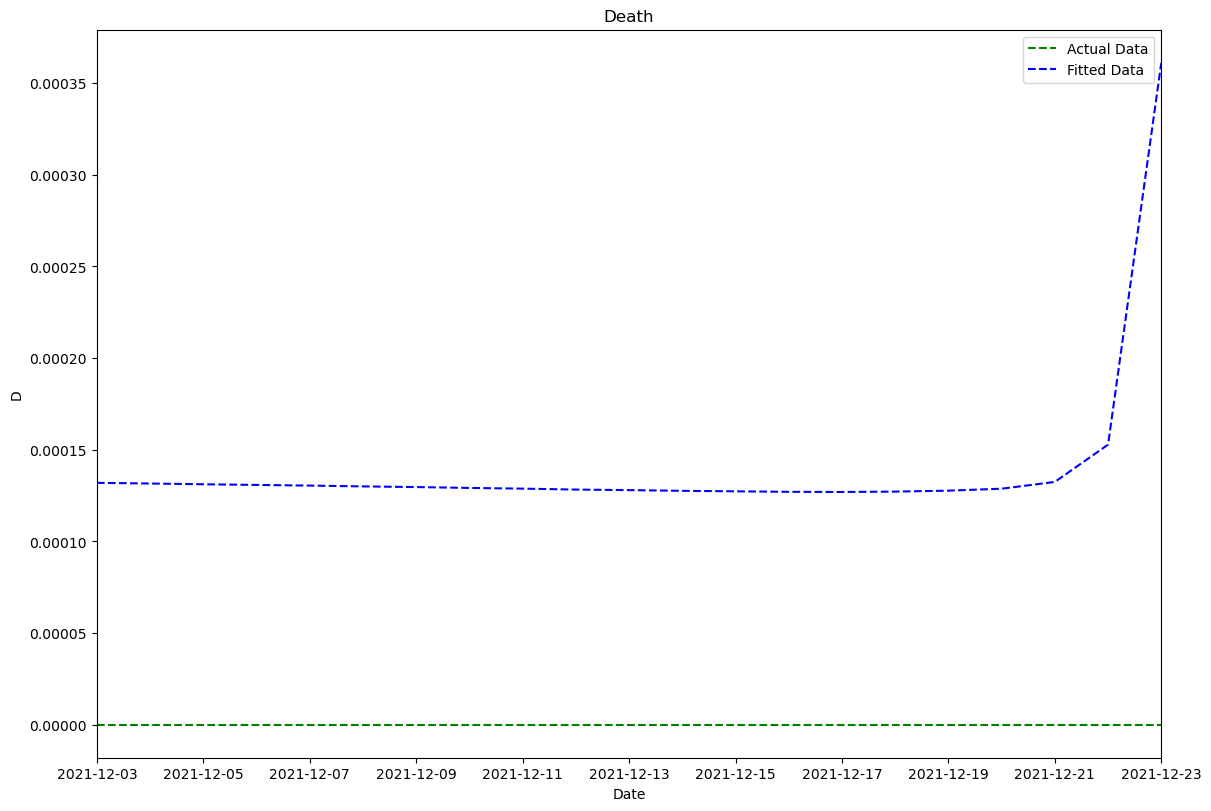

In [16]:
fig1, ax1 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax1.plot(dates,DD/N0, '--g')
ax1.plot(dates,D_pred.flatten().tolist(), '--b')

ax1.set_xlabel('Date')
ax1.set_ylabel('D')
ax1.set_title('Death')
ax1.set_xlim(lims)
ax1.legend(['Actual Data', r'Fitted Data'])

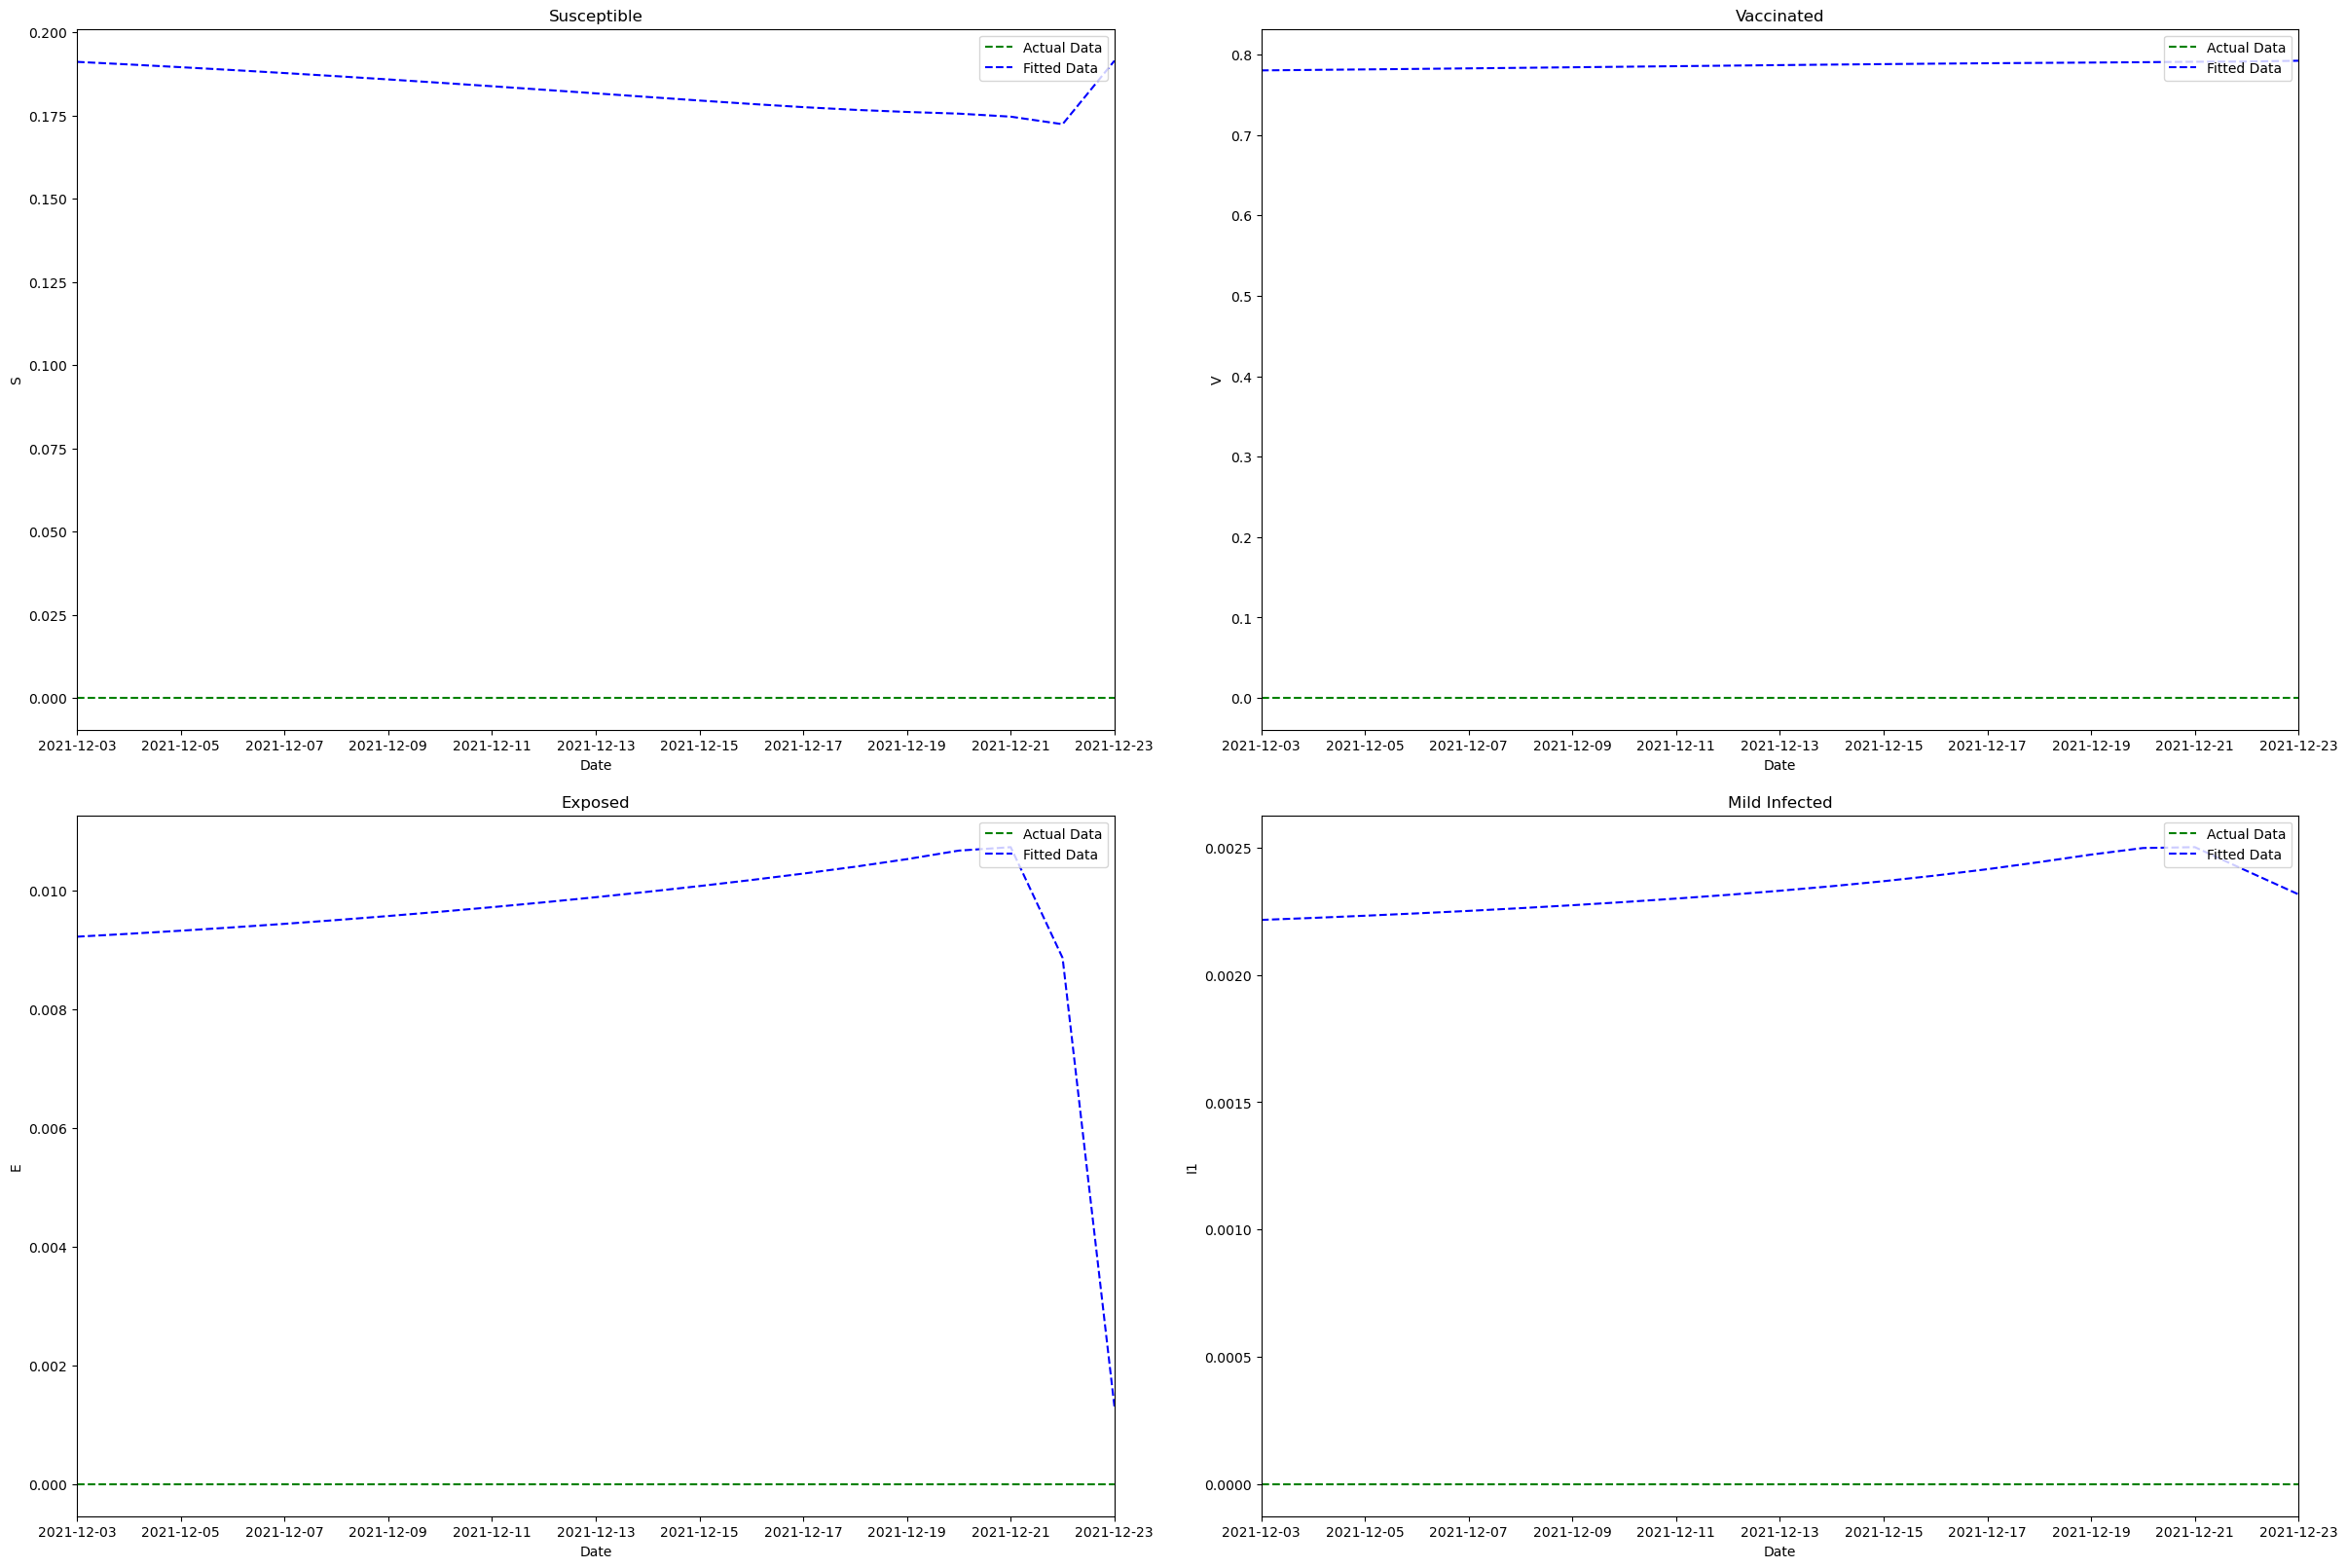

In [17]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(24, 16))

# Custom plots for each subplot
def plot_1(ax):
    ax.plot(dates,SS/N0, '--g')
    ax.plot(dates,S_pred.flatten().tolist(), '--b')
    ax.set_xlabel('Date')
    ax.set_ylabel('S')
    ax.set_title('Susceptible')
    ax.set_xlim(lims)
    ax.legend(['Actual Data', r'Fitted Data'], loc='upper right')


def plot_2(ax):
    ax.plot(dates,VV/N0, '--g')
    ax.plot(dates,V_pred.flatten().tolist(), '--b')
    ax.set_xlabel('Date')
    ax.set_ylabel('V')
    ax.set_title('Vaccinated')
    ax.set_xlim(lims)
    ax.legend(['Actual Data', r'Fitted Data'], loc='upper right')


def plot_3(ax):
    ax.plot(dates,EE/N0, '--g')
    ax.plot(dates,E_pred.flatten().tolist(), '--b')
    ax.set_xlabel('Date')
    ax.set_ylabel('E')
    ax.set_title('Exposed')
    ax.set_xlim(lims)
    ax.legend(['Actual Data', r'Fitted Data'], loc='upper right')


def plot_4(ax):
    ax.plot(dates,I1I/N0, '--g')
    ax.plot(dates,I1_pred.flatten().tolist(), '--b')
    ax.set_xlabel('Date')
    ax.set_ylabel('I1')
    ax.set_title('Mild Infected')
    ax.set_xlim(lims)
    ax.legend(['Actual Data', r'Fitted Data'], loc='upper right')


# Apply different plots to each subplot
plot_1(axs[0, 0])
plot_2(axs[0, 1])
plot_3(axs[1, 0])
plot_4(axs[1, 1])

# Display the plot
#plt.show()
plt.savefig('det_test_data_fitting_'+str(POINTS)+'xpoints_'+str(GRID)+'0%grid_seed'+str(SEED)+'.png')

In [18]:
print('TOTAL_RMSE', total_rmse)
print('TOTAL_MAPE', total_mape)

TOTAL_RMSE 0.005057094639950407
TOTAL_MAPE 3.4546200292110325


In [19]:
print('alpha_cal =', alpha)
print('sigma_cal =', sigma) 
print('beta1_cal =', beta1) 
print('beta2_cal =', beta2)
print('beta3_cal =', beta3)
print('delta1_cal =', delta1)
print('delta2_cal =', delta2)
print('delta3_cal =', delta3)
print('gamma_cal =', gamma)
print('p1_cal =', p1)
print('p2_cal =', p2)
print('mu_cal =', mu)

alpha_cal = 0.00171
sigma_cal = 0.00529
beta1_cal = 0.34863
beta2_cal = 0.22323
beta3_cal = 0.06289
delta1_cal = 0.30836
delta2_cal = 0.20983
delta3_cal = 0.07253
gamma_cal = 0.22657
p1_cal = 0.02337
p2_cal = 0.08008
mu_cal = 0.00532


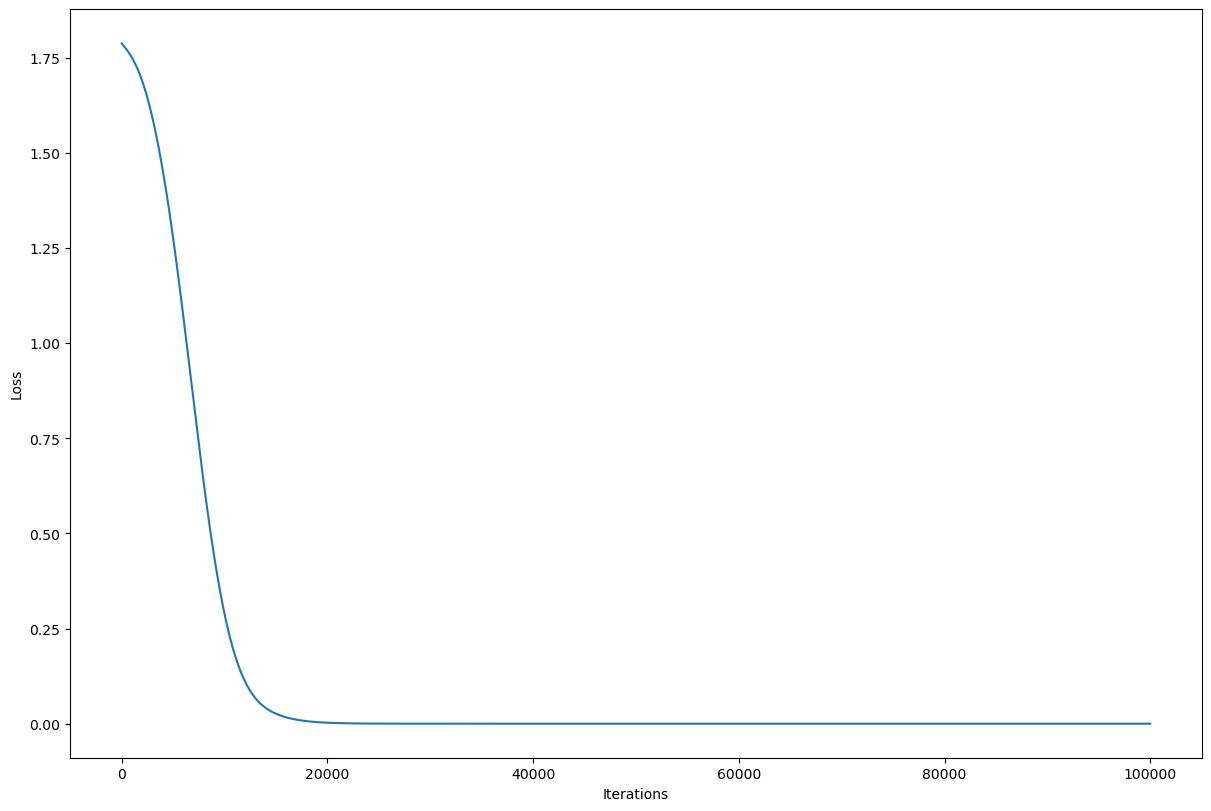

In [20]:
fig2, ax2 = plt.subplots(1, 1,constrained_layout=True,figsize=(12, 8))
ax2.plot(total_loss)
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
plt.savefig('det_test_loss_'+str(POINTS)+'xpoints_'+str(GRID)+'0%grid_seed'+str(SEED)+'.png')